# Homework 3: Voxel-Based 3D Reconstruction
#### Name: Syed Zain Raza
#### CWID: 20011917

In [1]:
# optional: allow Jupyter to "hot reload" the modules we import - after each change, rerun this cell (instead of restarting the kernel!!)
%load_ext autoreload
%autoreload 2

## Step 1: Define a Voxel Grid

Note to Self: the hw description mentions the dimensions of the voxel grid are measured in **meters**.

In [2]:
import numpy as np

In [3]:
X_RESOLUTION, Y_RESOLUTION, Z_RESOLUTION = (50, 50, 50)  # hope this doesn't raise a OOM error later
X_MIN, Y_MIN, Z_MIN = (-2.5, -3, 0)
X_DISTANCE, Y_DISTANCE, Z_DISTANCE = (5, 6, 2.5)

In [4]:
x_axis = np.linspace(X_MIN, X_MIN + X_DISTANCE, X_RESOLUTION)
y_axis = np.linspace(Y_MIN, Y_MIN + Y_DISTANCE, Y_RESOLUTION)
z_axis = np.linspace(Z_MIN, Z_MIN + Z_DISTANCE, Z_RESOLUTION)

The next line might be unnecessary - it's just that I find the `meshgrid()` function so cool:

In [5]:
x_coords, y_coords, z_coords = np.meshgrid(x_axis, y_axis, z_axis, indexing="ij")

## Step 2: Determine the Voxels Forming the Visual Hull

### Load the Silhouette Images and Camera Projection Matrices

Before anything else, let's play around to check if we can even load the projection matrix:

In [6]:
import xml.etree.ElementTree as ET

tree = ET.parse("../dancer/calibration/cam00.xml")
root = tree.getroot()
vals = [float(val) for val in root.text.split()]
cam_transform = np.array(vals).reshape(3, 4)
cam_transform

array([[ 7.76649963e+02, -2.98408539e+02, -3.20483860e+01,
         9.93158188e+02],
       [ 1.32852554e+02,  1.20885834e+02, -7.59210876e+02,
         1.98217400e+03],
       [ 7.44869000e-01,  6.62592000e-01, -7.83770000e-02,
         4.62931201e+00]])

Mission accomplished! Let's switch focus to seeing the silhouette images can be loaded:

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from util import ops

Dimensions of ../dancer/silh_cam00_00023_0000008550.pbm: 582 x 780
Only 2 possible pixel values: [  0 255]


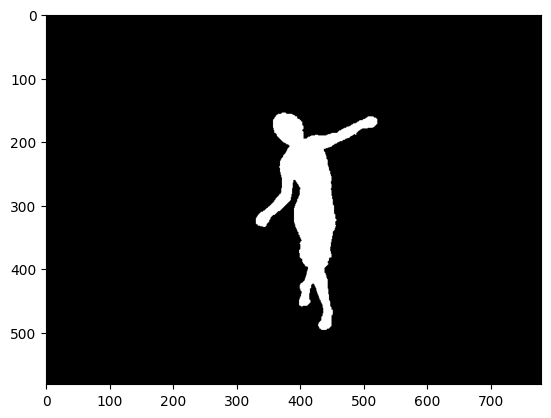

In [8]:
test_silhouette = ops.load_image(
    "../dancer/silh_cam00_00023_0000008550.pbm",
    return_grayscale=True,
    return_array=True
)
print(f"Only 2 possible pixel values: {np.unique(test_silhouette)}")
plt.imshow(test_silhouette, cmap="gray")
plt.show()

In [9]:
import glob

cam_transform_paths = glob.glob("../dancer/calibration/*")
silhouette_paths = glob.glob("../dancer/silh*")

Let's confirm if `glob.glob()` indeed return paths that are relative, so we know they don't need too much further preprocessing:

In [10]:
silhouette_paths

['../dancer/silh_cam07_00023_0000008550.pbm',
 '../dancer/silh_cam02_00023_0000008550.pbm',
 '../dancer/silh_cam06_00023_0000008550.pbm',
 '../dancer/silh_cam03_00023_0000008550.pbm',
 '../dancer/silh_cam00_00023_0000008550.pbm',
 '../dancer/silh_cam05_00023_0000008550.pbm',
 '../dancer/silh_cam01_00023_0000008550.pbm',
 '../dancer/silh_cam04_00023_0000008550.pbm']

In [11]:
cam_transform_paths

['../dancer/calibration/cam01.xml',
 '../dancer/calibration/cam00.xml',
 '../dancer/calibration/cam02.xml',
 '../dancer/calibration/cam03.xml',
 '../dancer/calibration/cam07.xml',
 '../dancer/calibration/cam06.xml',
 '../dancer/calibration/cam04.xml',
 '../dancer/calibration/cam05.xml']

As we can see above, for some reason the `glob` function returns the file paths in unsorted order. We should make a mental note to correct this later. Ideally, I would like to have the corresponding silhouette images and camera transforms at the same index in both lists.

In [12]:
import xml.etree.ElementTree as ET

import numpy as np

from util import ops


WHITE_PIXEL_VALUE = 255


def determine_visual_hull(
        scene_shape: tuple[int, int, int],
        scene_coords: tuple[np.ndarray, np.ndarray, np.ndarray],
        cam_transform_paths: list[str],
        silhouette_paths: list[str],
        debug_mode: bool = False,
        white_pixel_val: int = WHITE_PIXEL_VALUE
    ) -> np.ndarray:
    """
    Evaluates which voxels are empty and which are occupied.

    Be careful: this code ASSUMES that there is an equal number of
    strings in both `cam_transform_paths` and `silhouette_paths`, AND
    that each index position in these lists refers to the same
    captured frame of the 3D scene!

    Example:
    >>> occupied_space = determine_visual_hull(
    ...     (50, 50, 50),  # arbitrary, but probably best to use the same value for each axis
    ...     (x_coords, y_coords, z_coords),  # pre-computed set of all XYZ coords in world space
    ...     sorted(cam_transform_paths),
    ...     sorted(silhouette_paths),
    ...     debug_mode=True,  # good for initial testing
    ...     white_pixel_val=1,
    ... )

    Parameters:
        scene_shape(array-like): 1D row vector with 3 elements for the resolution
            of the grid's XYZ axes
        scene_coords(tuple[nd.ndarray]): 3-tuple representing the set of
            all pre-computed XYZ coords in world space.
        cam_transform_paths(list): relative paths to XML files serializing the 3x4
            projection matrix for each frame
        silhouette_paths(list): relative paths to the binary images showing where
            the subject of each frame is located in the scene
        debug_mode(bool): enables debug logs. Default is False.
        white_pixel_val(np.int8): the value representing occupied space in the
            silhouette images. Default is 255 for the purpose of hw3.

    Returns: np.ndarray: binary 3D array of shape = scene_shape. Occupied space
        will be encoded as 1, and empty space is 0.
    """
    ### HELPER(S)
    def _get_camera_transform_from_xml(path_to_transform: str) -> np.ndarray:
        """Reads serialized form of a projection matrix into a 3x4 NumPy array."""
        tree = ET.parse(path_to_transform)
        root = tree.getroot()
        vals = [float(val) for val in root.text.split()]
        return np.array(vals).reshape(3, 4)

    ### DRIVER
    # A: define a 3D array - for now, only possible colors are 0 (empty) or 1 (occupied)
    x_resolution, y_resolution, z_resolution = scene_shape
    x_coords, y_coords, z_coords = scene_coords
    voxels = np.zeros((x_resolution, y_resolution, z_resolution))
    if debug_mode:
        print(f"[DEBUG] voxels array: {type(voxels), voxels.shape}")
    # B: create a dict of all the camera projection matricies --> silhouette images
    num_frames = len(cam_transform_paths)
    frames_to_projection_and_silhouette = dict()
    for frame_index in range(num_frames):
        cam_transform_path = cam_transform_paths[frame_index]
        silhouette_path = silhouette_paths[frame_index]
        cam_transform = _get_camera_transform_from_xml(cam_transform_path)
        silhouette_image = ops.load_image(
            silhouette_path,
            return_grayscale=True,
            return_array=True,
            verbosity=debug_mode,
        )
        frames_to_projection_and_silhouette[frame_index] = (
            cam_transform, silhouette_image
        )
    # C: for each 3D index in the 3D array
    for x_index in np.arange(x_resolution):
        for y_index in np.arange(y_resolution):
            for z_index in np.arange(z_resolution):
                # get the corresponding 3D location in world space
                X = x_coords[x_index, y_index, z_index]
                Y = y_coords[x_index, y_index, z_index]
                Z = z_coords[x_index, y_index, z_index]
                world_coords_homogenous = np.array([X, Y, Z, 1]).reshape(4, 1)
                # init how many frames this location is in the visual hull
                num_images_in_silhouette = 0
                for frame_index in range(len(frames_to_projection_and_silhouette)):
                    cam_transform, silhouette_image = frames_to_projection_and_silhouette[frame_index]
                    # get the 2D image location in homo coords
                    image_xy_homogenous = np.dot(cam_transform, world_coords_homogenous).reshape(1, 3)
                    # convert to "pixel coords" - for numpy reasons, we need to round so we have integers
                    pixel_x = int(image_xy_homogenous[0, 0] // image_xy_homogenous[0, 2])
                    pixel_y = int(image_xy_homogenous[0, 1] // image_xy_homogenous[0, 2])
                    if debug_mode:
                        print(f"[DEBUG] does this coord transform look right? {(x_index, y_index, z_index)} --> {(X, Y, Z)} --> {pixel_x, pixel_y}")
                    # check the value of the location in the silhoute - increment value of num_images_in_silhouette
                    if (
                        # arguably, we should skip processing of any pixel coords w/ invalid array indices - as they are out of FOV
                        -1 < pixel_y < silhouette_image.shape[0] and
                        -1 < pixel_x < silhouette_image.shape[1] and
                        silhouette_image[pixel_y, pixel_x] == white_pixel_val
                    ):
                        if debug_mode:
                            print(f"[DEBUG] coords {pixel_y, pixel_x} are in bounds and have pixel val: {silhouette_image[pixel_y, pixel_x]}")
                        num_images_in_silhouette += 1
                # if the projection was in the silhouette  for all --> set the 3D index to be (occupied)
                if num_frames == num_images_in_silhouette:
                    if debug_mode:
                        print(f"[DEBUG] voxel @ {x_index, y_index, z_index} is occupied!")
                    voxels[x_index, y_index, z_index] = 1

    # Report the total number and what relatve portion of all voxels are in the visual hull
    num_occupied = int(voxels.sum())
    percent_occupied = num_occupied / np.prod(scene_shape)
    print(f"=========== Identifying Occupied Voxels.... ===========")
    print(f"Total number: {num_occupied}.")
    print(f"Percentage of grid voxels: {percent_occupied * 100}%.")
    return voxels

In [13]:
occupied_space = determine_visual_hull(
    (X_RESOLUTION, Y_RESOLUTION, Z_RESOLUTION),
    (x_coords, y_coords, z_coords),
    sorted(cam_transform_paths),
    sorted(silhouette_paths),
    debug_mode=False,
)

=========== Identifying Occupied Voxels.... ===========
Total number: 150.
Percentage of grid voxels: 0.12%.


In [14]:
type(occupied_space), occupied_space.shape

(numpy.ndarray, (50, 50, 50))

In [15]:
occupied_space.sum()

150.0

Woohoo! Looks like we have 150 occupied voxels - so something worked!

## Step 3: Identify Surface Voxels

Surface = occupied + have >= 1 empty neighbor

In [16]:
np.unique(occupied_space)

array([0., 1.])

In [17]:
import numpy as np


def identify_surface_voxels(
        occupancy_voxel_grid: np.ndarray,
        debug_mode: bool = False,
    ) -> list[np.ndarray]:
    """
    Brute force search for the voxels in the reconstructed surface.

    Will also report the total number, and percentage of surface
    voxels there are out of the total number of voxel grid cells.

    Parameters:
        occupany_voxel_grid(np.ndarray): 3D NumPy array - a binary
            voxel grid where 1 = occupied space, and zero is empty.
        debug_mode(bool): enables debug logs. Default is False.

    Returns: np.ndarray: an nx3 matrix, it will have n rows
        (where n = the number of surface voxels), each having 3
        elements which each represent the index location of a
        unique surface voxel in the grid.
    """
    ### HELPER(S)
    def _get_neighbor_array_indices(x_index: int, y_index: int, z_index: int) -> np.ndarray:
        """Compute array indices in 6 directions (one for each face of a cuboid voxel)."""
        neighbor_indices = np.array([
            [x_index - 1, y_index, z_index],
            [x_index + 1, y_index, z_index],
            [x_index, y_index - 1, z_index],
            [x_index, y_index + 1, z_index],
            [x_index, y_index, z_index - 1],
            [x_index, y_index, z_index + 1],
        ])
        return neighbor_indices

    ### DRIVER
    surface_voxels = set()

    # find the surface voxels
    occupied_index_locations = np.where(occupancy_voxel_grid == 1.)
    occupied_indices = np.column_stack(occupied_index_locations)
    if debug_mode:
        print(f"[DEBUG] No. occupied spaces: {occupied_indices.shape[0]}.")
        print(f"[DEBUG] Indices of non-empty space: {occupied_indices}.")
    for x_index, y_index, z_index in occupied_indices:
        if debug_mode:
            print(f"[DEBUG] current occupied voxel: {x_index, y_index, z_index}")
        # ***[SUSPECT] search all the neighbors - 1st implementation, I thought we should search in all 10 directions ****
        # neighbor_indices_x = list(set([
        #     max(0, x_index - 1),
        #     x_index,
        #     min(x_index + 1, occupancy_voxel_grid.shape[0] - 1)
        # ]))
        # neighbor_indices_y = list(set([
        #     max(0, y_index - 1),
        #     y_index,
        #     min(y_index + 1, occupancy_voxel_grid.shape[1] - 1)
        # ]))
        # neighbor_indices_z = list(set([
        #     max(0, z_index - 1),
        #     z_index,
        #     min(z_index + 1, occupancy_voxel_grid.shape[2] - 1)
        # ]))
        # num_empty = 0
        # for neighbor_x in neighbor_indices_x:
        #     for neighbor_y in neighbor_indices_y:
        #         for neighbor_z in neighbor_indices_z:
        #             if debug_mode:
        #                 print(f"[DEBUG] current neighbor voxel: {neighbor_x, neighbor_y, neighbor_z}")
        #             neighbor_occupancy = occupancy_voxel_grid[
        #                 neighbor_x,
        #                 neighbor_y,
        #                 neighbor_z
        #             ]
        #           # we'll end up checking the voxel itself, but that's ok b/c it's guaranteed to be 1
        #           if (
        #               -1 < neighbor_x < occupied_space.shape[0]
        #               and -1 < neighbor_y < occupied_space.shape[1]
        #               and -1 < neighbor_z < occupied_space.shape[2]
        #               and neighbor_occupancy == 0.
        #           ):
        #               num_empty += 1
        # ***[SUSPECT] search all the neighbors - 2nd implementation, I thought we should search on all 6 faces - probably the correct way ****
        neighbor_indices = _get_neighbor_array_indices(x_index, y_index, z_index)
        num_empty = 0
        for neighbor_x, neighbor_y, neighbor_z in neighbor_indices:
            if debug_mode:
                print(f"[DEBUG] current neighbor voxel: {neighbor_x, neighbor_y, neighbor_z}")
            neighbor_occupancy = occupancy_voxel_grid[
                neighbor_x,
                neighbor_y,
                neighbor_z
            ]
            if (
                -1 < neighbor_x < occupied_space.shape[0]
                and -1 < neighbor_y < occupied_space.shape[1]
                and -1 < neighbor_z < occupied_space.shape[2]
                and neighbor_occupancy == 0.
            ):
                num_empty += 1
        if num_empty > 0:
            surface_voxels.add((x_index, y_index, z_index))

    # report total num and % of surface voxels
    surface_voxels = np.asarray([[x_i, y_i, z_i] for (x_i, y_i, z_i) in surface_voxels])
    print(f"=========== Identifying Surface Voxels.... ===========")
    num_surface_voxels = surface_voxels.shape[0]
    total_num_voxels = np.prod(occupancy_voxel_grid.shape)
    print(f"Total number: {num_surface_voxels}.")
    print(f"Percentage of grid voxels: {(num_surface_voxels / total_num_voxels) * 100}%.")

    return surface_voxels


In [18]:
surface_voxels_indices = identify_surface_voxels(occupied_space, debug_mode=False)

=========== Identifying Surface Voxels.... ===========
Total number: 145.
Percentage of grid voxels: 0.116%.


Looks like 145 of the occupied voxels are on the surface - is this weird???

## Step 4: Determine the Set of 3D Points to Include in the Output

1. **Note to self**: a good future optimization could be to compute this, at the same time as step 3 - because we're going to end up double checking the 6 faces of the set of surface voxels...

2. **Note to self**: a lot of these functions are reusing the same input/output vars - if I get a chance to make a `util` module from this assignment, I should probably look to make a class where all these redundant variables become instance vars or something, so we have better encapsulation of data...

In [19]:
from enum import StrEnum
import numpy as np


class VoxelNeighbor(StrEnum):
    """Defines all the directions we look for neighbors to a 3D voxel in."""
    TOP = "top"
    BOTTOM = "bottom"
    LEFT = "left"
    RIGHT = "right"
    FRONT = "front"
    BACK = "back"


def determine_3d_model_points(
        occupancy_voxel_grid: np.ndarray,
        surface_voxels_indices: np.ndarray,
        worldspace_axis_distances: tuple[float],
        scene_shape: tuple[int, int, int],
        min_xyz_coordinates: tuple[float, float, float] = (0, 0, 0),
        debug_mode: bool = False,
    ) -> np.ndarray:
    """
    TODO[Zain] add docstring

    Parameters:
        occupancy_voxel_grid - 3D array representing a voxel grid of scene. 0 = empty; and 1 = occupied.
        surface_voxels_indices - Nx3 array of the index positions of surface voxels
        scene_coords(tuple[nd.ndarray]): 3-tuple representing the set of
            all pre-computed XYZ coords in world space.
    """
    ### HELPER(S)
    def _get_neighbor_array_indices(x_index: int, y_index: int, z_index: int) -> dict[VoxelNeighbor, list[int]]:
        """Compute array indices in 6 directions (one for each face of a cuboid voxel)."""
        neighbor_indices = dict(zip(
            [
                VoxelNeighbor.LEFT,
                VoxelNeighbor.RIGHT,
                VoxelNeighbor.BOTTOM,
                VoxelNeighbor.TOP,
                VoxelNeighbor.FRONT,
                VoxelNeighbor.BACK
            ],
            [
                [x_index - 1, y_index, z_index],  # left
                [x_index + 1, y_index, z_index],  # right
                [x_index, y_index - 1, z_index],  # bottom
                [x_index, y_index + 1, z_index],  # up
                [x_index, y_index, z_index - 1],  # front
                [x_index, y_index, z_index + 1],  # back
            ]
        ))
        return neighbor_indices

    def _get_face_center_points(x_index: int, y_index: int, z_index: int) -> dict[VoxelNeighbor, tuple[float]]:
        """TODO[Zain]: add docstring"""
        x, y, z = x_index, y_index, z_index

        # Calculate the center points of each face
        top_face_center = (x, y + 0.5, z)
        bottom_face_center = (x, y - 0.5, z)
        right_face_center = (x + 0.5, y, z)
        left_face_center = (x - 0.5, y, z)
        back_face_center = (x, y, z + 0.5)
        front_face_center = (x, y, z - 0.5)

        return {
            VoxelNeighbor.TOP: top_face_center,
            VoxelNeighbor.BOTTOM: bottom_face_center,
            VoxelNeighbor.RIGHT: right_face_center,
            VoxelNeighbor.LEFT: left_face_center,
            VoxelNeighbor.BACK: back_face_center,
            VoxelNeighbor.FRONT: front_face_center,
        }

    ### DRIVER
    # A: unravel the inputs
    x_distance, y_distance, z_distance = worldspace_axis_distances
    x_resolution, y_resolution, z_resolution = scene_shape
    min_world_x, min_world_y, min_world_z = min_xyz_coordinates

    # B: compute the voxel sizes
    voxel_size_x, voxel_size_y, voxel_size_z = (
        x_distance / x_resolution,
        y_distance / y_resolution,
        z_distance / z_resolution,
    )
    if debug_mode:
        print(f"[DEBUG] voxel_sizes are: {voxel_size_x, voxel_size_y, voxel_size_z}")

    # C: iterate over the indices provided in surface_voxels_indices
    model_points_to_include = set()
    for x_index, y_index, z_index in surface_voxels_indices:
        # check which of the six faces are empty - get a list
        neighbor_indices = _get_neighbor_array_indices(x_index, y_index, z_index)
        # use `_get_face_center_points` to also get the index positions of the center of the faces of the voxel
        center_coords_of_faces = _get_face_center_points(x_index, y_index, z_index)
        if debug_mode:
            print(f"[DEBUG] neighbor_indices are: {neighbor_indices}")
            print(f"[DEBUG] center_coords_of_faces are: {center_coords_of_faces}")
        # then select the indices of face centers, based on which are facing an empty neighbor
        for face_name, neighbor_3d_index_pos in neighbor_indices.items():
            neighbor_i, neighbor_j, neighbor_k = neighbor_3d_index_pos
            if (
                -1 < neighbor_i < occupancy_voxel_grid.shape[0]
                and -1 < neighbor_j < occupancy_voxel_grid.shape[1]
                and -1 < neighbor_k < occupancy_voxel_grid.shape[2]
                and occupancy_voxel_grid[neighbor_i, neighbor_j, neighbor_k] == 0
            ):
                point_i, point_j, point_k = center_coords_of_faces[face_name]
                if (
                    -1 < point_i < occupancy_voxel_grid.shape[0]
                    and -1 < point_j < occupancy_voxel_grid.shape[1]
                    and -1 < point_k < occupancy_voxel_grid.shape[2]
                ):
                    # include this in the 3D model, as world space coords
                    X = point_i * voxel_size_x + min_world_x
                    Y = point_j * voxel_size_y + min_world_y
                    Z = point_k * voxel_size_z + min_world_z
                    model_points_to_include.add((X, Y, Z))
                    if debug_mode:
                        print(
                            f"[DEBUG] '{face_name.value}' neighbor to surface voxel @ {x_index, y_index, z_index} is empty. "
                            f"I'm converting point indices ({point_i, point_j, point_k}) -> ({X, Y, Z}) and including in the model."
                        )
    model_points_to_include = np.asarray([
        list(xyz_point_location) for xyz_point_location in model_points_to_include
    ])

    # D: Report the number 3D points included in the model and compare with the number of voxels in the surface.
    print(f"=========== Identifying Points to Include in the Model.... ===========")
    num_points = model_points_to_include.shape[0]
    num_surface_voxels = surface_voxels_indices.shape[0]
    print(f"Total number: {num_points}.")
    if num_points > num_surface_voxels:
        print(f"This is greater than the number of surface voxels, {num_surface_voxels}.")
    elif num_points == num_surface_voxels:
        print(f"This is the same as the number of surface voxels, {num_surface_voxels}.")
    else:  # num_points < surface_voxels_indices.shape[0]
        print(f"This is less than the number of surface voxels, {num_surface_voxels}.")

    return model_points_to_include

In [20]:
points_for_3d_model = determine_3d_model_points(
    occupied_space,
    surface_voxels_indices,
    worldspace_axis_distances=(X_DISTANCE, Y_DISTANCE, Z_DISTANCE),
    scene_shape=(X_RESOLUTION, Y_RESOLUTION, Z_RESOLUTION),
    min_xyz_coordinates=(X_MIN, Y_MIN, Z_MIN),
    debug_mode=True,
)

[DEBUG] voxel_sizes are: (0.1, 0.12, 0.05)
[DEBUG] neighbor_indices are: {<VoxelNeighbor.LEFT: 'left'>: [26, 12, 9], <VoxelNeighbor.RIGHT: 'right'>: [28, 12, 9], <VoxelNeighbor.BOTTOM: 'bottom'>: [27, 11, 9], <VoxelNeighbor.TOP: 'top'>: [27, 13, 9], <VoxelNeighbor.FRONT: 'front'>: [27, 12, 8], <VoxelNeighbor.BACK: 'back'>: [27, 12, 10]}
[DEBUG] center_coords_of_faces are: {<VoxelNeighbor.TOP: 'top'>: (27, 12.5, 9), <VoxelNeighbor.BOTTOM: 'bottom'>: (27, 11.5, 9), <VoxelNeighbor.RIGHT: 'right'>: (27.5, 12, 9), <VoxelNeighbor.LEFT: 'left'>: (26.5, 12, 9), <VoxelNeighbor.BACK: 'back'>: (27, 12, 9.5), <VoxelNeighbor.FRONT: 'front'>: (27, 12, 8.5)}
[DEBUG] 'left' neighbor to surface voxel @ (27, 12, 9) is empty. I'm converting point indices ((26.5, 12, 9)) -> ((0.15000000000000036, -1.56, 0.45)) and including in the model.
[DEBUG] 'right' neighbor to surface voxel @ (27, 12, 9) is empty. I'm converting point indices ((27.5, 12, 9)) -> ((0.25, -1.56, 0.45)) and including in the model.
[DEBUG

In [21]:
145 * 6

870

In [22]:
(377 / 870) * 100

43.333333333333336

### Why are there so many points?

As we can see above, the number of points our algorithm determined should be included in the 3D model is 378, which is greater than the number of surface voxels, 145. One possible explanation for this happening is because for each surface voxel, we have up to 6 neighbors to check. For this specific "dancer" scene that has `145` surface voxels, that means there are up to `145 * 6 = 870` points we could include in the model. We determined `377` of those points should actually be in the model, or about `43.45%` of `870`. This situation is probably due to the nature of the 3D dancer scene we're analyzing, and could be lower/higher for other scenes where more/less of the neighbors to surface voxels are themselves empty.

## Step 5: Determine the False-Color RGB for Each Output 3D Point


In [23]:
import functools
import numpy as np

def determine_false_colors(
        points_for_3d_model: np.ndarray,
        dtype: np.dtype = np.uint8
    ) -> np.ndarray:
    """
    Assigns RGB values to points in a 3D volume based on min-max scaling.

    RGB values will fall between 0 and the max integer in whatever data type
    we're using (default is 255, for unsigned 8-bit integers).

    Parameters:
        points_for_3d_model(2D NumPy array): contains nx3 values - the XYZ worldspace
            coordinates of each point included in the 3D model
        dtype(np.dtype): determines the range of pixel values assigned per channel

    Returns: np.ndarray: contains nx3 values - RGB vectors for each input point.
    """
    ### HELPER(S)
    def _compute_rgb(
            xyz: np.ndarray,
            X_min: float, X_max: float,
            Y_min: float, Y_max: float,
            Z_min: float, Z_max: float,
            dtype: np.dtype,
        ) -> np.ndarray:
        """Assign an RGB value to a *single* XYZ worldspace location."""
        max_pixel_value = np.iinfo(dtype).max  # 255 if using uint8
        xyz = xyz.reshape((3,))
        red = max_pixel_value * (xyz[0] - X_min) / (X_max - X_min)
        green = max_pixel_value * (xyz[1] - Y_min) / (Y_max - Y_min)
        blue = max_pixel_value * (xyz[2] - Z_min) / (Z_max - Z_min)
        return np.asarray([red, green, blue])

    ### DRIVER
    # compute the "range bounding box" - min and max along X, Y, and Z
    X_min, X_max = points_for_3d_model[:, 0].min(), points_for_3d_model[:, 0].max()
    Y_min, Y_max = points_for_3d_model[:, 1].min(), points_for_3d_model[:, 1].max()
    Z_min, Z_max = points_for_3d_model[:, 2].min(), points_for_3d_model[:, 2].max()

    # reduce redundant passing of variables
    _compute_rgb_simplified = functools.partial(
        _compute_rgb,
        X_min=X_min,
        X_max=X_max,
        Y_min=Y_min,
        Y_max=Y_max,
        Z_min=Z_min,
        Z_max=Z_max,
        dtype=dtype,
    )

    # add
    false_color_rgb = np.apply_along_axis(
        _compute_rgb_simplified,
        1,
        points_for_3d_model,
    )

    return false_color_rgb

In [24]:
false_rgb_values = determine_false_colors(points_for_3d_model)
assert false_rgb_values.shape == (points_for_3d_model.shape[0], 3)

## Step 6: Write a PLY File

In [25]:
from io import TextIOWrapper

import functools
import numpy as np

def save_colored_point_cloud(
    xyz_points: np.ndarray,
    rgb_values: np.ndarray,
    path_to_save: str = "./myColoredPtCloud.ply",
) -> None:
    """
    Serializes a point cloud as a PLY file in the ASCII format.

    We use 3 `float` properties to represent the XYZ locations of each point,
    and 3 `uchar` properties to represent their respective RGB values.

    Parameters:
        xyz_points(2D NumPy array): contains nx3 values - the XYZ worldspace
            coordinates of each point included in the 3D model
        rgb_values(2D NumPy array): contains nx3 values - the corresponding
            RGB assignments for each input point.
        path_to_save(str): save location of the output PLY.
            Assumes the file name and the ".ply" extension are included at
            the end. It will be displayed in a log message if/when the
            save process is successfully completed.

    Returns: None
    """
    ### HELPER(S)
    def _write_one_point(xyz_rgb_1point: np.ndarray, f: TextIOWrapper) -> None:
        xyz_1point, rgb_1point = xyz_rgb_1point[:3], xyz_rgb_1point[3:]

        xyz_list_repr = xyz_1point.tolist()
        xyz_str_repr = str(xyz_list_repr)
        xyz_ply_repr = " ".join(xyz_str_repr[1:-1].split(","))

        rgb_list_repr = rgb_1point.astype(int).tolist()  # because it fits into the uchar type
        rgb_str_repr = str(rgb_list_repr)
        rgb_ply_repr = " ".join(rgb_str_repr[1:-1].split(","))

        f.write(f"{xyz_ply_repr} {rgb_ply_repr}\n")

    ### DRIVER
    num_vertices = xyz_points.shape[0]
    xyz_rgb_all = np.column_stack([xyz_points, rgb_values])

    with open(path_to_save, "w") as f:
        # write the header
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {num_vertices}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("element face 0\n")
        f.write("end_header\n")
        # write the points and their colors
        _write_one_point_simplified = functools.partial(_write_one_point, f=f)
        np.apply_along_axis(_write_one_point_simplified, 1, xyz_rgb_all)

    print(f"Point cloud saved to {path_to_save}.")

In [26]:
save_colored_point_cloud(
    points_for_3d_model,
    false_rgb_values,
    path_to_save="./Syed_Raza_PtCloudFalseColors.ply",
)

Point cloud saved to ./Syed_Raza_PtCloudFalseColors.ply.


### Test: Visualize in Point Cloud

Couldn't find a way to download Meshlab due to macOS not allowing downloads from places other than the App Store. Let's go with Open3D here (commented out for now, as it appears to crash the Jupyter kernel):

In [27]:
# import open3d as o3d

# %matplotlib widget

# point_cloud = o3d.io.read_point_cloud("./Syed_Raza_PtCloudFalseColors.ply")

# # Visualize the point cloud
# o3d.visualization.draw_geometries([point_cloud])

## Step 7: Determine the True RGB Colors

In [28]:
import functools

import numpy as np
from scipy import linalg as sci_alg

def determine_rgb_colors(
    occupancy_voxel_grid: np.ndarray,
    cam_transform_paths: list[str],
    rgb_paths: list[str],
    silhouette_paths: list[str],
    scene_shape: tuple[int, int, int],
    scene_dimensions: tuple[float, float, float],
    min_xyz_coordinates: np.ndarray,
    debug_mode: bool = False,
) -> np.ndarray:
    """
    TODO[Zain]: add docstring
    """
    ### HELPER(S)
    def _associate_frame_info():
        num_frames = len(cam_transform_paths)
        frames_to_projection_and_images = dict()
        for frame_index in range(num_frames):
            cam_transform_path = cam_transform_paths[frame_index]
            silhouette_path = silhouette_paths[frame_index]
            rgb_path = rgb_paths[frame_index]
            cam_transform = _get_camera_transform_from_xml(cam_transform_path)
            silhouette_image = ops.load_image(
                silhouette_path,
                return_grayscale=True,
                return_array=True,
                verbosity=debug_mode,
            )
            rgb_image = ops.load_image(
                rgb_path,
                return_grayscale=False,
                return_array=True,
                verbosity=debug_mode,
            )
            frames_to_projection_and_images[frame_index] = (
                cam_transform, silhouette_image, rgb_image
            )
        return frames_to_projection_and_images

    def _get_camera_transform_from_xml(path_to_transform: str) -> np.ndarray:
        """Reads serialized form of a projection matrix into a 3x4 NumPy array."""
        tree = ET.parse(path_to_transform)
        root = tree.getroot()
        vals = [float(val) for val in root.text.split()]
        return np.array(vals).reshape(3, 4)

    def _convert_index_location_to_worldspace(
            index_location_ijk: np.ndarray,
            voxel_size_xyz: np.ndarray,
            min_world_xyz: np.ndarray
        ) -> np.ndarray:
        point_i, point_j, point_k = index_location_ijk
        voxel_size_x, voxel_size_y, voxel_size_z = voxel_size_xyz
        min_world_x, min_world_y, min_world_z = min_world_xyz
        X = point_i * voxel_size_x + min_world_x
        Y = point_j * voxel_size_y + min_world_y
        Z = point_k * voxel_size_z + min_world_z
        return np.array([[X, Y, Z]])

    def _compute_step_size(
            index_location_ijk1: np.ndarray | tuple,
            index_location_ijk2: np.ndarray | tuple,
            voxel_size_xyz: np.ndarray,
            min_world_xyz: np.ndarray
        ) -> np.ndarray:
        # because our grid is a cuboid (all axis are equal length), the distance between 2 adjacent voxels is the same, regardless of orientation
        # so compute the worldspace coords of (0, 0, 0) and (0, 0, 1) respectively; then compute the magnitude of their difference
        world_xyz1 = _convert_index_location_to_worldspace(index_location_ijk1, voxel_size_xyz, min_world_xyz)
        world_xyz2 = _convert_index_location_to_worldspace(index_location_ijk2, voxel_size_xyz, min_world_xyz)
        return np.linalg.norm(world_xyz2 - world_xyz1)

    def _convert_worldspace_to_index_location(
            world_coordinates: np.ndarray,
            voxel_size_xyz: np.ndarray,
            min_world_xyz: np.ndarray,
        ) -> np.ndarray:
        """do the opposite of _convert_index_location_to_worldspace"""
        world_coordinates = world_coordinates.squeeze()
        X, Y, Z = world_coordinates
        voxel_size_x, voxel_size_y, voxel_size_z = voxel_size_xyz
        min_world_x, min_world_y, min_world_z = min_world_xyz
        point_i = (X - min_world_x) / voxel_size_x
        point_j = (Y - min_world_y) / voxel_size_y
        point_k = (Z - min_world_z) / voxel_size_z
        return np.array([[point_i, point_j, point_k]])

    def _convert_worldspace_to_image_space(world_coordinate: np.ndarray, cam_transform: np.ndarray) -> np.ndarray:
        world_coordinate_homogenous = np.concatenate([world_coordinate, [1]]).reshape(4, 1)
        image_xy_homogenous = np.dot(cam_transform, world_coordinate_homogenous).reshape(1, 3)
        # convert to "pixel coords" - for numpy reasons, we need to round so we have integers
        pixel_x = int(image_xy_homogenous[0, 0] // image_xy_homogenous[0, 2])
        pixel_y = int(image_xy_homogenous[0, 1] // image_xy_homogenous[0, 2])
        return pixel_x, pixel_y

    def _sample_coordinates(translation: np.ndarray, cam_center_coords_worldspace: np.ndarray, step_size: float) -> np.ndarray:
        translation_magnitude = np.linalg.norm(translation)
        num_steps = int(translation_magnitude / step_size)
        sampled_coordinates = []
        for i in range(num_steps + 1):  # Include the endpoint
            # Compute the coordinates of the sampled point
            sampled_point = cam_center_coords_worldspace + (translation * (i / num_steps))
            sampled_coordinates.append(sampled_point)
        sample_coordinates = np.asarray(sampled_coordinates)
        # for each step location, in XYZ
        sample_array_indices = np.apply_along_axis(
            _convert_worldspace_to_index_location,
            1,
            sample_coordinates,
        )
        return sample_array_indices

    def _bresenham_line(start_index: np.ndarray, end_index: np.ndarray) -> np.ndarray:
        """
        Generates a list of array indices that lie on
        the line segment between two given elements in
        the 3D voxel grid.
        """
        # Get start and end points
        x0, y0, z0 = start_index
        x1, y1, z1 = end_index

        # Compute differences and absolute differences
        dx = np.abs(x1 - x0)
        dy = np.abs(y1 - y0)
        dz = np.abs(z1 - z0)

        # Determine the increments for each axis
        sx = np.sign(x1 - x0)
        sy = np.sign(y1 - y0)
        sz = np.sign(z1 - z0)

        # Initialize error terms
        err1 = dx - dy
        err2 = dx - dz

        # Initialize current position
        x, y, z = x0, y0, z0

        # Initialize list to store line points
        line_points = []

        # Iterate along the line
        while x != x1 or y != y1 or z != z1:
            # Add current point to the line
            line_points.append((x, y, z))

            # Compute next position
            e2 = 2 * err1
            e3 = 2 * err2

            if e2 > -dy:
                err1 -= dy
                x += sx
            if e3 > -dz:
                err2 -= dz
                y += sy

            if e2 < dx:
                err1 += dx
                y += sy
            if e3 < dx:
                err2 += dx
                z += sz

        # Add the endpoint to the line
        line_points.append((x1, y1, z1))

        return np.asarray(line_points)

    def _color_coordinate(
            world_coordinate: np.ndarray,
            step_size: float,
            frames_to_projection_and_images: dict[int, tuple[np.ndarray, np.ndarray, np.ndarray]],
        ) -> np.ndarray:

        rgb_pixel_colors = []

        # iterate over all the silhouette images + respective camera projections
        for _, frame_data in frames_to_projection_and_images.items():
            frame_projection, silhouette_image, rgb_image = frame_data
            # fail fast - first project the XYZ location into the image - check if it's in the silhouette - if it's not, don't continue
            pixel_x, pixel_y = _convert_worldspace_to_image_space(world_coordinate, frame_projection)
            if (
                (-1 < pixel_y < silhouette_image.shape[0])
                and (-1 < pixel_x < silhouette_image.shape[1])
            ):
                # figure out location of cam - use null space of 3x4 - 4x1 --> convert to non-homo coords
                cam_center = sci_alg.null_space(frame_projection).reshape(1, 4)  # initially is a 4x1
                cam_center_coords_worldspace = cam_center[0, :3] / cam_center[0, 3]
                # compute the translation vector going from the XYZ point --> cam
                translation = world_coordinate - cam_center_coords_worldspace  # (beware the order)!!!
                sample_array_indices = _sample_coordinates(translation, cam_center_coords_worldspace, step_size)
                # search along the translation vector to check visibility
                is_visible = True
                for index in range(sample_array_indices.shape[0] - 1):
                    current_sample_index = sample_array_indices[index, :]
                    next_index = sample_array_indices[index + 1, :]
                    rasterized_indices = _bresenham_line(current_sample_index, next_index)

                    # Check each voxel along the line segment in the voxel grid
                    for index in rasterized_indices:
                        if occupancy_voxel_grid[index] == 1:  # Occupied voxel
                            # if the point is visible - add the RGB value from the image to an array
                            if debug_mode:
                                print(f"Voxel at {index} is occupied. Pixel ({pixel_x}, {pixel_y}) is not visible.")
                            is_visible = False
                        elif debug_mode:
                            print(f"Voxel at {index} is NOT occupied.")
                if is_visible:
                    rgb_pixel_colors.append(rgb_image[pixel_y, pixel_x, :].reshape(1, 3))

        # compute the RGB for the point in the 3d model
        rgb_pixel_colors = np.asarray(rgb_pixel_colors)
        if len(rgb_pixel_colors.shape) == 2 and rgb_pixel_colors.shape[0] > 0:
            return tuple(np.median(rgb_pixel_colors, axis=1).squeeze())
        else:
            return (0, 0, 0)

    ### DRIVER
    # load all images and projection matrices in ordered lists
    frames_to_projection_and_images = _associate_frame_info()

    # compute the step size to sample along the translation vector
    x_resolution, y_resolution, z_resolution = scene_shape
    x_distance, y_distance, z_distance = scene_dimensions
    voxel_size_xyz = np.array([
        x_distance / x_resolution,
        y_distance / y_resolution,
        z_distance / z_resolution
    ])
    assert x_resolution == y_resolution == z_resolution, f"I assumed the voxel grid was a cube, but this is false. Actual shape is {scene_shape}."
    assert isinstance(min_xyz_coordinates, np.ndarray)
    step_size = _compute_step_size(
        min_xyz_coordinates,
        min_xyz_coordinates + 1,
        voxel_size_xyz,
        min_xyz_coordinates,
    )

    # color all points
    _color_coordinate_simplified = functools.partial(
        _color_coordinate,
        step_size=step_size,
        frames_to_projection_and_silhouette=frames_to_projection_and_images,
    )

    rgb_colors = np.apply_along_axis(
        _color_coordinate_simplified,
        1,
        points_for_3d_model,
    )

    return rgb_colors
